In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [7]:
from sklearn.model_selection import train_test_split

data = np.array([], dtype=np.float32)
labels = np.array([], dtype=np.float32)

with open('data.npy', 'rb') as f:
    data = np.load(f)

with open('labels.npy', 'rb') as f:
    labels = np.load(f)

torch.cuda.empty_cache()

data = np.expand_dims(data, axis=1)
data = torch.from_numpy(data).to(torch.float).to(device)

labels = (labels == 'AD').astype(int)
labels = np.expand_dims(labels, axis=1)
labels = torch.from_numpy(labels).to(torch.float).to(device)

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=1/4, random_state=0)

In [8]:
class AlzNet(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 128, 11)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 98, 9)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(98, 40, 7)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(40, 20, 5)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(200, 97)
        self.fc2 = nn.Linear(97, 30)
        self.dropout = nn.Dropout(p)
        self.fc3 = nn.Linear(30, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = torch.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

In [9]:
alznet = AlzNet().to(torch.float).to(device)

criterion = nn.BCELoss().to(torch.float)
optimizer = optim.SGD(alznet.parameters(), lr=0.001, momentum=0.9)


In [10]:
epochs = 5

data_batches = torch.chunk(x_train, 1038)
labels_batches = torch.chunk(y_train, 1038)

losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, (X, Y) in enumerate(zip(data_batches, labels_batches)):

        outputs = alznet(X)
        loss = criterion(outputs, Y[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 49:
            losses.append(running_loss / 50)
            print(f'epoch {i}\tloss : {running_loss / 50}')
            running_loss = 0.0


epoch 49	loss : 0.6832414019107819
epoch 99	loss : 0.6388124680519104
epoch 149	loss : 0.6933472061157226
epoch 199	loss : 0.681906179189682
epoch 249	loss : 0.6424843168258667
epoch 299	loss : 0.6951129806041717
epoch 349	loss : 0.6379214107990265
epoch 399	loss : 0.6895878207683563
epoch 449	loss : 0.6663791191577911
epoch 499	loss : 0.6895023584365845
epoch 549	loss : 0.6339124882221222
epoch 599	loss : 0.5681325453519821
epoch 649	loss : 0.6870383471250534
epoch 699	loss : 0.697020155787468
epoch 749	loss : 0.5826418495178223
epoch 799	loss : 0.6991322249174118
epoch 849	loss : 0.6540512919425965
epoch 899	loss : 0.708467527627945
epoch 949	loss : 0.6838316851854325
epoch 49	loss : 0.6656794512271881
epoch 99	loss : 0.573463117480278
epoch 149	loss : 0.7102729320526123
epoch 199	loss : 0.6860671186447144
epoch 249	loss : 0.6236941295862198
epoch 299	loss : 0.7059419775009155
epoch 349	loss : 0.6248821014165878
epoch 399	loss : 0.6957513254880905
epoch 449	loss : 0.6652196359634399


In [ ]:
# data_batches[0].shape
x_train.shape
y_train.shape
# labels_batches[0].shape

torch.Size([3240, 1])

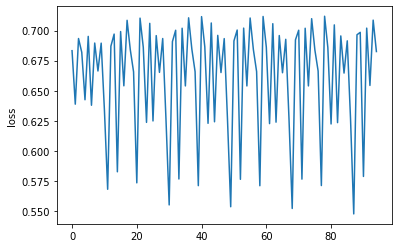

In [15]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.show()